In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cv2

%matplotlib notebook

In [2]:
exp_dir = '/home/manor/anaconda3/envs/openAIenv/baselines/models/BreakoutNoFrameskip-v4_4e7_a2c_exp_2019-09-28_11-00-00'
obs_dir = os.path.join(exp_dir, 'obs_dir')
other_dir = os.path.join(exp_dir, 'other_info')
exp_dir = os.path.abspath(exp_dir)
obs_dir = os.path.abspath(obs_dir)
other_dir = os.path.abspath(other_dir)
assert os.path.exists(exp_dir)
assert os.path.exists(obs_dir)
assert os.path.exists(other_dir)

os.chdir(exp_dir)

In [3]:
obs = []
for obs_file in os.listdir(obs_dir):
    obs.append(np.load(os.path.join(obs_dir, obs_file)))
obs = np.concatenate([o for o in obs], axis=0)
rew = []
for info_file in os.listdir(other_dir):
    rew.append(np.load(os.path.join(other_dir, info_file))['accumulated_reward_episodic'])
rew = np.concatenate([o for o in rew], axis=0)

print("obs shape : {}, obs dtype: {}\nrew shape : {}, rew dtype : {}".format(obs.shape, obs.dtype, rew.shape, rew.dtype))

obs shape : (26542, 84, 84, 4), obs dtype: uint8
rew shape : (26534, 1), rew dtype : float32


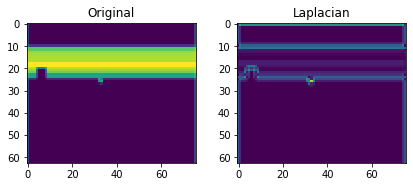

(63, 76)


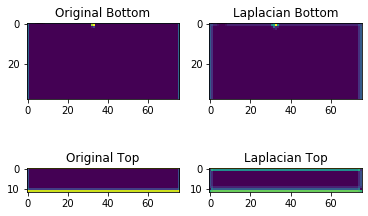

(12, 76)
(38, 76)


In [4]:
fig,ax = plt.subplots(1,2)
plt.tight_layout()
curr_obs = obs[100,12:75,4:80,3]
curr_obs_lap        = np.abs(cv2.Laplacian(curr_obs,cv2.CV_64F))
ax[0].imshow(curr_obs)
ax[0].set_title('Original')
ax[1].imshow(curr_obs_lap)
ax[1].set_title('Laplacian')
plt.show()
print(curr_obs.shape)

fig,ax = plt.subplots(2,2)
curr_obs_bottom     = curr_obs[25:,:]
curr_obs_bottom_lap = np.abs(cv2.Laplacian(curr_obs_bottom,cv2.CV_64F))
curr_obs_top      = curr_obs[:12,:]
curr_obs_top_lap  = np.abs(cv2.Laplacian(curr_obs_top,cv2.CV_64F))
ax[0,0].imshow(curr_obs_bottom)
ax[0,0].set_title('Original Bottom')
ax[0,1].imshow(curr_obs_bottom_lap)
ax[0,1].set_title('Laplacian Bottom')
ax[1,0].imshow(curr_obs_top)
ax[1,0].set_title('Original Top')
ax[1,1].imshow(curr_obs_top_lap)
ax[1,1].set_title('Laplacian Top')
plt.show()
print(curr_obs_top.shape)
print(curr_obs_bottom.shape)

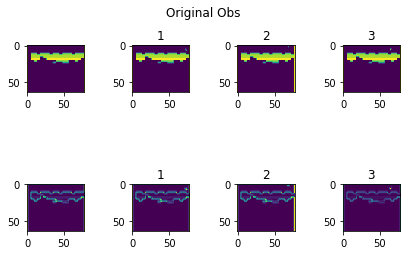

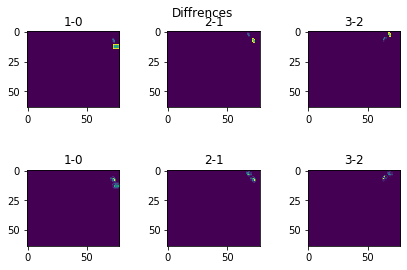

In [5]:
fig,ax = plt.subplots(2,4)
plt.tight_layout()
curr_obs = obs[1000,11:75,3:81,:]
curr_obs_lap = np.abs(cv2.Laplacian(curr_obs,cv2.CV_64F))
ax[0,0].imshow(curr_obs[:,:,0])
ax[0,1].set_title('0')
ax[0,1].imshow(curr_obs[:,:,1])
ax[0,1].set_title('1')
ax[0,2].imshow(curr_obs[:,:,2])
ax[0,2].set_title('2')
ax[0,3].imshow(curr_obs[:,:,3])
ax[0,3].set_title('3')
ax[1,0].imshow(curr_obs_lap[:,:,0])
ax[1,1].set_title('0')
ax[1,1].imshow(curr_obs_lap[:,:,1])
ax[1,1].set_title('1')
ax[1,2].imshow(curr_obs_lap[:,:,2])
ax[1,2].set_title('2')
ax[1,3].imshow(curr_obs_lap[:,:,3])
ax[1,3].set_title('3')


fig.suptitle('Original Obs')
plt.show()

diff32 = curr_obs[:,:,3] - curr_obs[:,:,2]
diff21 = curr_obs[:,:,2] - curr_obs[:,:,1]
diff10 = curr_obs[:,:,1] - curr_obs[:,:,0]
diff32_lap = abs(curr_obs_lap[:,:,3] - curr_obs_lap[:,:,2])
diff21_lap = abs(curr_obs_lap[:,:,2] - curr_obs_lap[:,:,1])
diff10_lap = abs(curr_obs_lap[:,:,1] - curr_obs_lap[:,:,0])

fig,ax = plt.subplots(2,3)
plt.tight_layout()
ax[0,0].imshow(diff10)
ax[0,0].set_title('1-0')
ax[0,1].imshow(diff21)
ax[0,1].set_title('2-1')
ax[0,2].imshow(diff32)
ax[0,2].set_title('3-2')
ax[1,0].imshow(diff10_lap)
ax[1,0].set_title('1-0')
ax[1,1].imshow(diff21_lap)
ax[1,1].set_title('2-1')
ax[1,2].imshow(diff32_lap)
ax[1,2].set_title('3-2')
fig.suptitle('Diffrences')
plt.show()


In [6]:
def get_ball_position(obs=None):
    assert obs is not None
    assert len(obs.shape) == 3 and obs.shape[0] == 84 and obs.shape[1] == 84 and obs.shape[2] == 4
    
    h_offset = 11
    w_offset = 2
    obs = obs[h_offset:75,w_offset:82,:]
    
    curr = obs[:,:,3]
    prev = obs[:,:,2]
    
    curr_lap = np.abs(cv2.Laplacian(curr,cv2.CV_64F))
    prev_lap = np.abs(cv2.Laplacian(prev,cv2.CV_64F))
    
    diff_lap = abs(curr_lap - prev_lap)
    
    _, max_val, _, max_loc = cv2.minMaxLoc(diff_lap)
    
    loc = max_loc + np.array([w_offset, h_offset])
    loc_a = (int(np.floor(max_loc[0]/8)), int(np.floor(max_loc[1]/8)))
    
    areas = {
        '0':(0,0),
        '1':(0,1),
        '2':(0,2),
        '3':(0,3),
        '4':(0,4),
        '5':(0,5),
        '6':(0,6),
        '7':(0,7),
        '8':(1,0),
        '9':(1,1),
        '10':(1,2),
        '11':(1,3),
        '12':(1,4),
        '13':(1,5),
        '14':(1,6),
        '15':(1,7),
        '16':(2,0),
        '17':(2,1),
        '18':(2,2),
        '19':(2,3),
        '20':(2,4),
        '21':(2,5),
        '22':(2,6),
        '23':(2,7),
        '24':(3,0),
        '25':(3,1),
        '26':(3,2),
        '27':(3,3),
        '28':(3,4),
        '29':(3,5),
        '30':(3,6),
        '31':(3,7),
        '33':(4,0),
        '34':(4,1),
        '35':(4,2),
        '36':(4,3),
        '37':(4,4),
        '38':(4,5),
        '39':(4,6),
        '40':(4,7),
        '41':(5,0),
        '42':(5,1),
        '43':(5,2),
        '44':(5,3),
        '45':(5,4),
        '46':(5,5),
        '47':(5,6),
        '48':(5,7),
        '49':(6,0),
        '50':(6,1),
        '51':(6,2),
        '52':(6,3),
        '53':(6,4),
        '54':(6,5),
        '55':(6,6),
        '56':(6,7),
        '57':(7,0),
        '58':(7,1),
        '59':(7,2),
        '60':(7,3),
        '61':(7,4),
        '62':(7,5),
        '63':(7,6),
        '64':(7,7),
        '65':(8,0),
        '66':(8,1),
        '67':(8,2),
        '68':(8,3),
        '69':(8,4),
        '70':(8,5),
        '71':(8,6),
        '72':(8,7),
        '73':(9,0),
        '74':(9,1),
        '75':(9,2),
        '76':(9,3),
        '77':(9,4),
        '78':(9,5),
        '79':(9,6),
        '80':(9,7)
    }
    
    for k,v in areas.items():
        if loc_a[0] == v[0] and loc_a[1] == v[1]:
            area = k
            break
    return max_val, loc, area

1116)  245.0 [36 71] 40
1117)  214.0 [26 59] 30
1118)  312.0 [23 55] 21
1119)  322.0 [19 49] 20
1120)  322.0 [19 49] 20
1121)  246.0 [15 44] 12
1122)  220.0 [ 6 33] 2
1123)  220.0 [ 6 33] 2
1124)  205.0 [ 5 26] 1
1125)  286.0 [14 15] 8
1126)  390.0 [18 15] 16
1127)  476.0 [21 19] 17
1128)  476.0 [21 19] 17
1129)  277.0 [25 25] 17
1130)  249.0 [35 21] 34
1131)  414.0 [39 15] 33


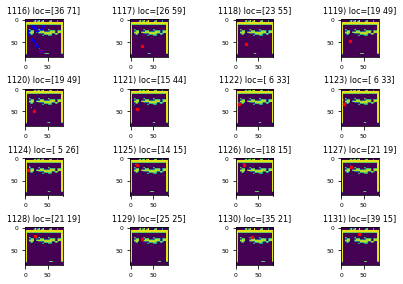

In [7]:
fig,axes = plt.subplots(4,4)
fig.tight_layout()
for i in range(16):
    idx = 1116+i
    obs_f = obs[idx,:,:,:]
    print('{}) '.format(idx), end=' ')
    val, loc, area = get_ball_position(obs_f)
    print(val, loc, area)
    axes[int(i/4),int(i%4)].set_title('{}) loc={}'.format(idx, loc), fontsize=8)
    axes[int(i/4),int(i%4)].tick_params(axis='both', which='major', labelsize=6)
    axes[int(i/4),int(i%4)].imshow(obs_f[:,:,3])
    axes[int(i/4),int(i%4)].scatter(loc[0], loc[1], s=6, c='red', marker='o')  
    axes[0,0].scatter(loc[0], loc[1], s=3, c='blue', marker='o')
plt.show()

In [8]:
locs  = []
areas = []
for i in range(obs.shape[0]):
    obs_f = obs[i,:,:,:]
    print('{}) '.format(i), end=' ')
    val, loc, area = get_ball_position(obs_f)
    print(val, loc, area)
    locs.append(loc)
    areas.append(area)

0)  286.0 [18 56] 21
1)  287.0 [20 58] 21
2)  287.0 [20 58] 21
3)  223.0 [24 61] 22
4)  237.0 [24 61] 22
5)  281.0 [29 65] 30
6)  289.0 [31 66] 30
7)  289.0 [31 66] 30
8)  280.0 [33 68] 31
9)  287.0 [37 71] 40
10)  287.0 [37 71] 40
11)  288.0 [41 74] 40
12)  146.0 [41 73] 40
13)  252.0 [39 71] 40
14)  252.0 [39 71] 40
15)  248.0 [37 69] 40
16)  303.0 [32 63] 30
17)  303.0 [32 63] 30
18)  273.0 [28 58] 29
19)  273.0 [28 58] 29
20)  258.0 [24 54] 21
21)  293.0 [22 52] 21
22)  293.0 [22 52] 21
23)  252.0 [18 47] 20
24)  252.0 [18 47] 20
25)  248.0 [16 45] 12
26)  303.0 [11 39] 11
27)  303.0 [11 39] 11
28)  288.0 [ 7 40] 3
29)  288.0 [ 7 40] 3
30)  188.0 [ 5 42] 3
31)  185.0 [ 7 48] 4
32)  290.0 [ 9 50] 4
33)  290.0 [ 9 50] 4
34)  288.0 [11 52] 13
35)  288.0 [15 57] 13
36)  288.0 [15 57] 13
37)  280.0 [17 59] 14
38)  290.0 [21 64] 22
39)  290.0 [21 64] 22
40)  269.0 [23 66] 22
41)  202.0 [25 69] 23
42)  248.0 [30 74] 31
43)  221.0 [30 74] 31
44)  264.0 [29 73] 31
45)  250.0 [27 70] 31
46) 

467)  187.0 [40 39] 36
468)  193.0 [44 42] 44
469)  253.0 [48 45] 45
470)  335.0 [53 49] 53
471)  335.0 [53 49] 53
472)  251.0 [56 51] 54
473)  193.0 [65 58] 62
474)  253.0 [69 61] 71
475)  335.0 [74 65] 79
476)  335.0 [74 65] 79
477)  262.0 [77 70] 80
478)  336.0 [72 74] 72
479)  336.0 [72 74] 72
480)  246.0 [68 73] 72
481)  201.0 [60 67] 64
482)  271.0 [55 63] 55
483)  347.0 [52 61] 55
484)  347.0 [52 61] 55
485)  246.0 [47 57] 46
486)  201.0 [39 51] 38
487)  271.0 [34 47] 37
488)  347.0 [31 45] 28
489)  347.0 [31 45] 28
490)  246.0 [26 41] 27
491)  189.0 [22 38] 19
492)  234.0 [13 42] 11
493)  282.0 [10 45] 12
494)  282.0 [10 45] 12
495)  271.0 [ 7 52] 5
496)  347.0 [10 54] 13
497)  347.0 [10 54] 13
498)  246.0 [15 58] 13
499)  201.0 [23 64] 22
500)  271.0 [28 68] 31
501)  347.0 [31 70] 31
502)  347.0 [31 70] 31
503)  244.0 [36 74] 40
504)  282.0 [31 70] 31
505)  282.0 [31 70] 31
506)  236.0 [26 66] 30
507)  169.0 [17 60] 14
508)  234.0 [13 57] 13
509)  282.0 [10 54] 13
510)  282.0 

917)  165.0 [16 37] 11
918)  368.0 [20 43] 20
919)  368.0 [20 43] 20
920)  283.0 [23 47] 20
921)  224.0 [27 52] 29
922)  271.0 [37 64] 39
923)  338.0 [40 68] 40
924)  338.0 [40 68] 40
925)  368.0 [42 71] 48
926)  368.0 [42 71] 48
927)  254.0 [37 64] 39
928)  201.0 [34 60] 39
929)  280.0 [24 48] 20
930)  368.0 [21 44] 20
931)  368.0 [21 44] 20
932)  263.0 [17 38] 11
933)  201.0 [13 41] 11
934)  201.0 [ 7 48] 4
935)  170.0 [ 7 59] 6
936)  174.0 [12 64] 14
937)  223.0 [15 68] 15
938)  242.0 [19 73] 23
939)  298.0 [17 71] 15
940)  298.0 [17 71] 15
941)  175.0 [ 7 59] 6
942)  175.0 [ 7 59] 6
943)  209.0 [ 6 49] 4
944)  209.0 [ 6 49] 4
945)  234.0 [16 37] 11
946)  320.0 [20 37] 19
947)  320.0 [20 37] 19
948)  320.0 [23 41] 19
949)  195.0 [27 47] 28
950)  271.0 [37 59] 39
951)  368.0 [41 64] 39
952)  368.0 [41 64] 39
953)  321.0 [44 68] 48
954)  155.0 [48 73] 48
955)  271.0 [58 64] 63
956)  337.0 [61 60] 63
957)  337.0 [61 60] 63
958)  321.0 [65 55] 62
959)  209.0 [69 49] 69
960)  175.0 [78 3

1387)  407.0 [41 26] 34
1388)  397.0 [44 22] 42
1389)  249.0 [48 16] 41
1390)  352.0 [58 21] 58
1391)  432.0 [62 26] 58
1392)  432.0 [62 26] 58
1393)  258.0 [66 30] 67
1394)  247.0 [69 27] 67
1395)  239.0 [78 16] 73
1396)  211.0 [78 14] 73
1397)  259.0 [77 15] 73
1398)  291.0 [68 26] 66
1399)  425.0 [65 30] 59
1400)  425.0 [65 30] 59
1401)  267.0 [60 37] 60
1402)  246.0 [57 41] 52
1403)  197.0 [48 52] 46
1404)  342.0 [43 59] 47
1405)  342.0 [43 59] 47
1406)  342.0 [40 63] 39
1407)  245.0 [36 68] 40
1408)  245.0 [26 72] 31
1409)  342.0 [22 67] 23
1410)  342.0 [19 63] 22
1411)  342.0 [19 63] 22
1412)  197.0 [14 56] 13
1413)  211.0 [ 6 47] 4
1414)  211.0 [ 6 47] 4
1415)  168.0 [ 5 40] 3
1416)  233.0 [14 29] 10
1417)  336.0 [17 25] 9
1418)  449.0 [21 19] 17
1419)  449.0 [21 19] 17
1420)  352.0 [25 14] 16
1421)  225.0 [29 16] 24
1422)  381.0 [39 29] 35
1423)  381.0 [39 29] 35
1424)  199.0 [42 33] 43
1425)  204.0 [50 25] 50
1426)  268.0 [56 18] 49
1427)  371.0 [59 14] 57
1428)  476.0 [63 16]

1865)  188.0 [55 41] 52
1866)  298.0 [45 40] 44
1867)  346.0 [42 44] 45
1868)  346.0 [42 44] 45
1869)  254.0 [37 51] 38
1870)  175.0 [34 55] 38
1871)  298.0 [24 67] 23
1872)  368.0 [21 71] 23
1873)  368.0 [21 71] 23
1874)  254.0 [16 72] 15
1875)  201.0 [13 68] 15
1876)  139.0 [ 8 63] 6
1877)  224.0 [ 6 52] 5
1878)  224.0 [ 6 52] 5
1879)  255.0 [16 40] 11
1880)  391.0 [20 34] 18
1881)  436.0 [23 30] 18
1882)  436.0 [23 30] 18
1883)  262.0 [27 25] 25
1884)  296.0 [36 14] 33
1885)  476.0 [41 18] 33
1886)  476.0 [41 18] 33
1887)  378.0 [44 22] 42
1888)  200.0 [49 29] 43
1889)  125.0 [51 33] 51
1890)  398.0 [61 25] 58
1891)  398.0 [61 25] 58
1892)  390.0 [65 19] 58
1893)  286.0 [69 14] 65
1894)  226.0 [78 22] 74
1895)  236.0 [77 29] 75
1896)  236.0 [77 29] 75
1897)  246.0 [68 40] 68
1898)  322.0 [64 45] 61
1899)  322.0 [64 45] 61
1900)  312.0 [60 51] 62
1901)  214.0 [57 55] 54
1902)  245.0 [47 67] 48
1903)  309.0 [44 71] 48
1904)  312.0 [39 72] 40
1905)  312.0 [39 72] 40
1906)  245.0 [36 68

2373)  317.0 [47 15] 41
2374)  419.0 [43 15] 41
2375)  445.0 [40 19] 34
2376)  445.0 [40 19] 34
2377)  252.0 [36 25] 34
2378)  213.0 [26 37] 27
2379)  342.0 [22 43] 20
2380)  342.0 [22 43] 20
2381)  309.0 [18 48] 20
2382)  246.0 [15 52] 13
2383)  191.0 [ 6 63] 6
2384)  191.0 [ 6 63] 6
2385)  119.0 [ 4 70] 7
2386)  197.0 [ 6 71] 7
2387)  197.0 [ 6 71] 7
2388)  174.0 [ 8 60] 6
2389)  174.0 [ 8 60] 6
2390)  320.0 [18 48] 20
2391)  368.0 [21 44] 20
2392)  368.0 [21 44] 20
2393)  271.0 [25 39] 19
2394)  261.0 [35 26] 34
2395)  365.0 [39 21] 34
2396)  476.0 [42 17] 41
2397)  476.0 [42 17] 41
2398)  331.0 [46 14] 41
2399)  261.0 [56 26] 50
2400)  287.0 [60 31] 59
2401)  296.0 [64 37] 60
2402)  296.0 [64 37] 60
2403)  271.0 [67 41] 68
2404)  170.0 [76 52] 78
2405)  170.0 [76 52] 78
2406)  201.0 [76 63] 79
2407)  201.0 [76 63] 79
2408)  183.0 [67 73] 72
2409)  224.0 [69 71] 72
2410)  224.0 [69 71] 72
2411)  174.0 [75 64] 79
2412)  189.0 [78 55] 78
2413)  189.0 [78 55] 78
2414)  214.0 [68 43] 69

2841)  253.0 [13 64] 14
2842)  234.0 [17 66] 14
2843)  253.0 [25 69] 23
2844)  295.0 [30 71] 31
2845)  295.0 [30 71] 31
2846)  253.0 [34 72] 40
2847)  258.0 [39 74] 40
2848)  287.0 [39 74] 40
2849)  261.0 [31 71] 31
2850)  261.0 [31 71] 31
2851)  246.0 [26 69] 31
2852)  253.0 [18 66] 22
2853)  253.0 [18 66] 22
2854)  261.0 [10 63] 14
2855)  261.0 [10 63] 14
2856)  179.0 [ 7 59] 6
2857)  261.0 [10 58] 13
2858)  261.0 [10 58] 13
2859)  253.0 [19 55] 21
2860)  253.0 [19 55] 21
2861)  252.0 [27 52] 29
2862)  261.0 [31 50] 28
2863)  261.0 [31 50] 28
2864)  253.0 [40 47] 37
2865)  253.0 [40 47] 37
2866)  252.0 [48 44] 45
2867)  261.0 [52 42] 52
2868)  261.0 [52 42] 52
2869)  253.0 [61 39] 60
2870)  253.0 [61 39] 60
2871)  202.0 [65 37] 60
2872)  295.0 [74 39] 76
2873)  295.0 [74 39] 76
2874)  235.0 [76 42] 76
2875)  282.0 [73 43] 69
2876)  282.0 [73 43] 69
2877)  253.0 [68 45] 69
2878)  253.0 [60 48] 61
2879)  253.0 [60 48] 61
2880)  282.0 [52 51] 54
2881)  282.0 [52 51] 54
2882)  253.0 [47 

3320)  198.0 [19 40] 19
3321)  262.0 [27 40] 27
3322)  274.0 [32 44] 28
3323)  274.0 [32 44] 28
3324)  217.0 [35 47] 37
3325)  182.0 [45 54] 46
3326)  262.0 [48 56] 46
3327)  274.0 [53 60] 55
3328)  274.0 [53 60] 55
3329)  217.0 [56 63] 55
3330)  182.0 [66 70] 72
3331)  262.0 [69 72] 72
3332)  262.0 [69 72] 72
3333)  251.0 [72 74] 72
3334)  217.0 [69 72] 72
3335)  182.0 [59 65] 63
3336)  262.0 [56 63] 55
3337)  274.0 [51 59] 55
3338)  274.0 [51 59] 55
3339)  217.0 [48 56] 46
3340)  182.0 [38 49] 37
3341)  262.0 [35 47] 37
3342)  274.0 [30 43] 28
3343)  274.0 [30 43] 28
3344)  217.0 [27 40] 27
3345)  146.0 [17 34] 10
3346)  177.0 [13 31] 10
3347)  293.0 [10 33] 10
3348)  293.0 [10 33] 10
3349)  308.0 [ 7 46] 4
3350)  368.0 [10 50] 12
3351)  368.0 [10 50] 12
3352)  239.0 [15 57] 13
3353)  188.0 [18 61] 22
3354)  308.0 [28 73] 31
3355)  308.0 [28 73] 31
3356)  305.0 [27 74] 31
3357)  210.0 [17 62] 14
3358)  270.0 [13 57] 13
3359)  368.0 [10 53] 13
3360)  368.0 [10 53] 13
3361)  270.0 [ 7 

3817)  265.0 [12 71] 15
3818)  253.0 [20 68] 23
3819)  253.0 [20 68] 23
3820)  253.0 [28 65] 30
3821)  265.0 [33 63] 30
3822)  265.0 [33 63] 30
3823)  253.0 [41 60] 39
3824)  253.0 [41 60] 39
3825)  253.0 [49 57] 46
3826)  265.0 [54 55] 54
3827)  265.0 [54 55] 54
3828)  253.0 [62 52] 62
3829)  253.0 [62 52] 62
3830)  253.0 [70 49] 69
3831)  265.0 [75 47] 77
3832)  265.0 [75 47] 77
3833)  253.0 [76 44] 77
3834)  295.0 [72 43] 69
3835)  295.0 [72 43] 69
3836)  253.0 [67 41] 68
3837)  214.0 [63 39] 60
3838)  200.0 [59 38] 60
3839)  164.0 [50 38] 52
3840)  253.0 [46 39] 44
3841)  253.0 [46 39] 44
3842)  253.0 [38 42] 36
3843)  256.0 [33 44] 28
3844)  274.0 [30 45] 28
3845)  274.0 [30 45] 28
3846)  253.0 [25 47] 20
3847)  253.0 [17 50] 12
3848)  256.0 [12 52] 13
3849)  274.0 [ 9 53] 5
3850)  274.0 [ 9 53] 5
3851)  275.0 [ 8 57] 5
3852)  275.0 [ 8 57] 5
3853)  254.0 [11 58] 13
3854)  240.0 [16 60] 14
3855)  253.0 [24 63] 22
3856)  275.0 [29 65] 30
3857)  275.0 [29 65] 30
3858)  254.0 [32 66]

4318)  268.0 [14 56] 13
4319)  325.0 [10 53] 13
4320)  325.0 [10 53] 13
4321)  289.0 [ 7 51] 5
4322)  274.0 [ 9 44] 4
4323)  274.0 [ 9 44] 4
4324)  262.0 [14 40] 11
4325)  248.0 [22 34] 18
4326)  262.0 [21 30] 18
4327)  260.0 [31 37] 27
4328)  260.0 [31 37] 27
4329)  253.0 [35 40] 36
4330)  193.0 [39 43] 37
4331)  251.0 [48 50] 45
4332)  335.0 [51 52] 54
4333)  335.0 [51 52] 54
4334)  253.0 [56 56] 54
4335)  193.0 [60 59] 63
4336)  251.0 [69 66] 71
4337)  335.0 [72 68] 72
4338)  335.0 [72 68] 72
4339)  253.0 [77 72] 80
4340)  256.0 [75 71] 80
4341)  274.0 [72 68] 72
4342)  274.0 [72 68] 72
4343)  213.0 [67 64] 71
4344)  192.0 [58 58] 62
4345)  256.0 [54 55] 54
4346)  274.0 [51 52] 54
4347)  274.0 [51 52] 54
4348)  213.0 [46 48] 45
4349)  192.0 [37 42] 36
4350)  256.0 [33 39] 27
4351)  256.0 [33 39] 27
4352)  226.0 [29 35] 27
4353)  266.0 [21 30] 18
4354)  208.0 [16 37] 11
4355)  333.0 [12 42] 11
4356)  356.0 [ 9 46] 4
4357)  356.0 [ 9 46] 4
4358)  295.0 [ 8 58] 5
4359)  356.0 [11 62] 1

4820)  439.0 [31 28] 26
4821)  439.0 [31 28] 26
4822)  210.0 [38 38] 36
4823)  210.0 [38 38] 36
4824)  285.0 [48 50] 45
4825)  353.0 [51 54] 54
4826)  353.0 [51 54] 54
4827)  269.0 [56 61] 55
4828)  210.0 [59 65] 63
4829)  284.0 [67 74] 72
4830)  284.0 [67 74] 72
4831)  182.0 [59 65] 63
4832)  333.0 [54 58] 54
4833)  356.0 [51 54] 54
4834)  356.0 [51 54] 54
4835)  259.0 [47 49] 45
4836)  178.0 [37 37] 36
4837)  296.0 [33 37] 27
4838)  325.0 [29 42] 27
4839)  325.0 [29 42] 27
4840)  259.0 [26 46] 28
4841)  207.0 [16 58] 13
4842)  296.0 [13 62] 14
4843)  335.0 [ 9 68] 7
4844)  335.0 [ 9 68] 7
4845)  251.0 [ 6 72] 7
4846)  368.0 [10 66] 14
4847)  368.0 [10 66] 14
4848)  270.0 [13 62] 14
4849)  210.0 [17 57] 13
4850)  285.0 [27 45] 28
4851)  353.0 [30 41] 27
4852)  353.0 [30 41] 27
4853)  236.0 [34 35] 36
4854)  262.0 [41 29] 35
4855)  285.0 [48 42] 44
4856)  353.0 [51 46] 53
4857)  353.0 [51 46] 53
4858)  269.0 [56 53] 54
4859)  210.0 [59 57] 62
4860)  268.0 [69 69] 72
4861)  391.0 [73 74

5290)  400.0 [44 15] 41
5291)  445.0 [40 20] 34
5292)  445.0 [40 20] 34
5293)  317.0 [36 18] 33
5294)  298.0 [26 19] 25
5295)  314.0 [23 23] 17
5296)  314.0 [23 23] 17
5297)  317.0 [15 18] 8
5298)  317.0 [15 18] 8
5299)  259.0 [ 6 18] 0
5300)  259.0 [ 6 18] 0
5301)  222.0 [ 5 25] 1
5302)  191.0 [13 34] 10
5303)  301.0 [18 41] 19
5304)  368.0 [21 45] 20
5305)  368.0 [21 45] 20
5306)  239.0 [25 51] 21
5307)  224.0 [35 63] 39
5308)  321.0 [39 68] 40
5309)  368.0 [42 72] 48
5310)  368.0 [42 72] 48
5311)  271.0 [46 72] 48
5312)  224.0 [56 60] 55
5313)  283.0 [60 55] 62
5314)  368.0 [63 51] 62
5315)  368.0 [63 51] 62
5316)  255.0 [67 45] 69
5317)  220.0 [77 33] 75
5318)  220.0 [77 33] 75
5319)  194.0 [75 22] 74
5320)  256.0 [70 16] 65
5321)  384.0 [66 14] 65
5322)  448.0 [63 18] 57
5323)  448.0 [63 18] 57
5324)  307.0 [58 25] 58
5325)  205.0 [55 29] 51
5326)  280.0 [45 41] 44
5327)  368.0 [42 45] 45
5328)  368.0 [42 45] 45
5329)  263.0 [38 51] 38
5330)  201.0 [34 56] 38
5331)  298.0 [24 68] 

5789)  222.0 [12 40] 11
5790)  272.0 [11 43] 12
5791)  290.0 [10 46] 12
5792)  303.0 [ 9 49] 4
5793)  303.0 [ 9 49] 4
5794)  304.0 [ 8 52] 5
5795)  213.0 [ 6 59] 6
5796)  213.0 [ 6 59] 6
5797)  146.0 [ 5 62] 6
5798)  151.0 [ 5 68] 7
5799)  162.0 [ 6 72] 7
5800)  185.0 [ 5 74] 7
5801)  185.0 [ 5 74] 7
5802)  134.0 [ 5 68] 7
5803)  248.0 [ 6 64] 6
5804)  250.0 [ 7 61] 6
5805)  292.0 [ 8 59] 6
5806)  292.0 [ 8 59] 6
5807)  280.0 [10 52] 13
5808)  313.0 [11 48] 12
5809)  313.0 [11 48] 12
5810)  272.0 [12 45] 12
5811)  269.0 [13 43] 12
5812)  212.0 [14 39] 11
5813)  128.0 [15 35] 11
5814)  203.0 [13 30] 10
5815)  133.0 [18 40] 19
5816)  133.0 [18 40] 19
5817)  116.0 [20 47] 20
5818)  124.0 [22 49] 20
5819)  160.0 [23 52] 21
5820)  160.0 [23 52] 21
5821)  172.0 [25 59] 22
5822)  225.0 [26 63] 30
5823)  230.0 [27 65] 30
5824)  269.0 [28 68] 31
5825)  269.0 [28 68] 31
5826)  252.0 [29 72] 31
5827)  350.0 [29 74] 31
5828)  253.0 [25 73] 23
5829)  234.0 [17 70] 15
5830)  253.0 [13 68] 15
5831)  

6294)  240.0 [16 55] 13
6295)  221.0 [25 48] 20
6296)  295.0 [29 45] 28
6297)  335.0 [32 43] 28
6298)  335.0 [32 43] 28
6299)  240.0 [37 39] 36
6300)  112.0 [41 35] 36
6301)  262.0 [42 30] 43
6302)  308.0 [54 39] 52
6303)  308.0 [54 39] 52
6304)  227.0 [57 41] 52
6305)  187.0 [66 48] 69
6306)  259.0 [70 51] 70
6307)  308.0 [75 55] 78
6308)  308.0 [75 55] 78
6309)  285.0 [76 60] 79
6310)  285.0 [76 60] 79
6311)  264.0 [71 64] 71
6312)  195.0 [68 67] 72
6313)  203.0 [59 73] 64
6314)  161.0 [58 74] 64
6315)  169.0 [59 73] 64
6316)  236.0 [68 67] 72
6317)  282.0 [73 63] 71
6318)  282.0 [73 63] 71
6319)  268.0 [77 56] 78
6320)  325.0 [73 53] 70
6321)  325.0 [73 53] 70
6322)  289.0 [70 51] 70
6323)  228.0 [65 47] 61
6324)  268.0 [56 40] 52
6325)  280.0 [53 38] 52
6326)  297.0 [53 38] 52
6327)  253.0 [48 40] 44
6328)  193.0 [44 43] 45
6329)  251.0 [35 50] 37
6330)  335.0 [32 52] 29
6331)  335.0 [32 52] 29
6332)  253.0 [27 56] 29
6333)  193.0 [23 59] 22
6334)  251.0 [14 66] 14
6335)  335.0 [11

6802)  366.0 [56 14] 49
6803)  448.0 [52 17] 49
6804)  448.0 [52 17] 49
6805)  374.0 [49 21] 42
6806)  273.0 [45 19] 42
6807)  366.0 [35 20] 34
6808)  448.0 [31 20] 25
6809)  448.0 [31 20] 25
6810)  396.0 [28 16] 24
6811)  256.0 [24 16] 16
6812)  366.0 [14 17] 8
6813)  420.0 [10 14] 8
6814)  420.0 [10 14] 8
6815)  349.0 [ 7 19] 1
6816)  495.0 [10 31] 10
6817)  495.0 [10 31] 10
6818)  195.0 [13 35] 11
6819)  182.0 [17 41] 11
6820)  285.0 [27 53] 29
6821)  368.0 [31 58] 29
6822)  368.0 [31 58] 29
6823)  307.0 [34 62] 39
6824)  204.0 [44 74] 48
6825)  239.0 [47 73] 48
6826)  368.0 [52 66] 55
6827)  368.0 [52 66] 55
6828)  307.0 [55 62] 55
6829)  210.0 [59 57] 62
6830)  251.0 [69 45] 69
6831)  368.0 [73 39] 68
6832)  368.0 [73 39] 68
6833)  223.0 [76 35] 76
6834)  495.0 [73 31] 67
6835)  495.0 [73 31] 67
6836)  195.0 [70 35] 68
6837)  182.0 [66 41] 68
6838)  285.0 [56 53] 54
6839)  368.0 [52 58] 54
6840)  368.0 [52 58] 54
6841)  307.0 [49 62] 47
6842)  204.0 [39 74] 40
6843)  239.0 [36 73]

7290)  458.0 [30 19] 25
7291)  458.0 [30 19] 25
7292)  285.0 [25 14] 16
7293)  255.0 [16 25] 9
7294)  448.0 [12 31] 10
7295)  448.0 [12 31] 10
7296)  229.0 [ 9 35] 3
7297)  314.0 [ 8 47] 4
7298)  326.0 [12 53] 13
7299)  326.0 [12 53] 13
7300)  227.0 [15 57] 13
7301)  236.0 [25 69] 23
7302)  356.0 [29 74] 31
7303)  356.0 [32 73] 31
7304)  356.0 [32 73] 31
7305)  212.0 [37 66] 39
7306)  182.0 [45 57] 46
7307)  333.0 [50 50] 53
7308)  356.0 [53 46] 53
7309)  356.0 [53 46] 53
7310)  259.0 [57 41] 52
7311)  236.0 [67 45] 69
7312)  333.0 [71 50] 69
7313)  356.0 [74 54] 78
7314)  356.0 [74 54] 78
7315)  333.0 [75 66] 79
7316)  356.0 [72 70] 72
7317)  356.0 [72 70] 72
7318)  368.0 [73 69] 72
7319)  368.0 [73 69] 72
7320)  307.0 [76 65] 79
7321)  353.0 [74 54] 78
7322)  353.0 [74 54] 78
7323)  307.0 [70 49] 69
7324)  196.0 [66 43] 69
7325)  183.0 [56 36] 52
7326)  368.0 [52 42] 52
7327)  368.0 [52 42] 52
7328)  290.0 [49 46] 45
7329)  187.0 [39 58] 38
7330)  239.0 [36 62] 39
7331)  368.0 [31 69

7780)  335.0 [ 9 46] 4
7781)  335.0 [ 9 46] 4
7782)  333.0 [ 8 58] 5
7783)  356.0 [11 62] 14
7784)  356.0 [11 62] 14
7785)  212.0 [16 69] 15
7786)  182.0 [24 73] 23
7787)  333.0 [29 66] 30
7788)  356.0 [32 62] 30
7789)  356.0 [32 62] 30
7790)  259.0 [36 57] 38
7791)  207.0 [46 45] 45
7792)  333.0 [50 39] 52
7793)  333.0 [50 39] 52
7794)  261.0 [53 35] 52
7795)  254.0 [57 30] 51
7796)  304.0 [67 17] 65
7797)  378.0 [71 14] 65
7798)  417.0 [75 20] 74
7799)  417.0 [75 20] 74
7800)  448.0 [75 31] 75
7801)  448.0 [75 31] 75
7802)  229.0 [72 35] 68
7803)  227.0 [68 41] 68
7804)  236.0 [58 53] 62
7805)  333.0 [54 58] 54
7806)  356.0 [51 62] 55
7807)  356.0 [51 62] 55
7808)  212.0 [46 69] 48
7809)  162.0 [43 73] 48
7810)  285.0 [35 66] 39
7811)  368.0 [31 61] 30
7812)  368.0 [31 61] 30
7813)  307.0 [28 57] 29
7814)  163.0 [18 45] 20
7815)  285.0 [14 39] 11
7816)  293.0 [10 33] 10
7817)  320.0 [ 6 28] 2
7818)  320.0 [ 6 28] 2
7819)  475.0 [10 17] 8
7820)  475.0 [10 17] 8
7821)  331.0 [14 14] 8


8192)  272.0 [44 47] 45
8193)  272.0 [44 47] 45
8194)  272.0 [45 50] 45
8195)  193.0 [48 58] 46
8196)  280.0 [49 61] 47
8197)  284.0 [50 64] 55
8198)  284.0 [50 64] 55
8199)  281.0 [51 67] 56
8200)  278.0 [52 70] 56
8201)  111.0 [53 74] 56
8202)  324.0 [52 70] 56
8203)  324.0 [52 70] 56
8204)  292.0 [51 67] 56
8205)  292.0 [50 65] 55
8206)  230.0 [49 61] 47
8207)  225.0 [47 54] 46
8208)  225.0 [47 54] 46
8209)  188.0 [46 51] 46
8210)  181.0 [45 49] 45
8211)  133.0 [44 45] 45
8212)  116.0 [41 38] 36
8213)  116.0 [41 38] 36
8214)  162.0 [39 31] 35
8215)  215.0 [38 28] 35
8216)  224.0 [37 26] 34
8217)  254.0 [36 22] 34
8218)  272.0 [35 19] 34
8219)  297.0 [34 16] 33
8220)  349.0 [33 14] 24
8221)  403.0 [32 16] 24
8222)  403.0 [32 16] 24
8223)  361.0 [31 20] 25
8224)  345.0 [29 27] 26
8225)  353.0 [28 30] 26
8226)  353.0 [28 30] 26
8227)  308.0 [27 32] 26
8228)  229.0 [26 37] 27
8229)  188.0 [25 39] 19
8230)  181.0 [24 42] 19
8231)  133.0 [23 46] 20
8232)  116.0 [20 53] 21
8233)  124.0 [19

8600)  259.0 [49 59] 47
8601)  253.0 [41 56] 38
8602)  253.0 [41 56] 38
8603)  254.0 [32 53] 29
8604)  259.0 [28 51] 29
8605)  259.0 [28 51] 29
8606)  253.0 [20 48] 20
8607)  253.0 [20 48] 20
8608)  254.0 [11 45] 12
8609)  259.0 [ 7 43] 4
8610)  259.0 [ 7 43] 4
8611)  254.0 [ 9 40] 3
8612)  275.0 [12 39] 11
8613)  275.0 [12 39] 11
8614)  253.0 [17 38] 11
8615)  240.0 [25 41] 19
8616)  254.0 [30 43] 28
8617)  275.0 [33 44] 28
8618)  275.0 [33 44] 28
8619)  253.0 [38 46] 37
8620)  240.0 [46 49] 45
8621)  254.0 [51 51] 54
8622)  275.0 [54 52] 54
8623)  275.0 [54 52] 54
8624)  253.0 [59 54] 62
8625)  240.0 [67 57] 70
8626)  254.0 [72 59] 71
8627)  275.0 [75 60] 79
8628)  275.0 [75 60] 79
8629)  274.0 [74 64] 79
8630)  274.0 [74 64] 79
8631)  256.0 [71 65] 71
8632)  253.0 [66 67] 72
8633)  253.0 [58 70] 64
8634)  274.0 [53 72] 56
8635)  274.0 [53 72] 56
8636)  256.0 [50 73] 56
8637)  262.0 [47 74] 48
8638)  253.0 [43 73] 48
8639)  252.0 [35 70] 40
8640)  261.0 [31 68] 31
8641)  261.0 [31 68

9092)  271.0 [34 62] 39
9093)  335.0 [32 64] 30
9094)  335.0 [32 64] 30
9095)  259.0 [28 68] 31
9096)  202.0 [22 74] 23
9097)  146.0 [22 74] 23
9098)  181.0 [24 68] 23
9099)  188.0 [25 65] 22
9100)  225.0 [26 63] 30
9101)  225.0 [26 63] 30
9102)  230.0 [28 56] 29
9103)  292.0 [29 52] 29
9104)  292.0 [30 49] 28
9105)  324.0 [31 47] 28
9106)  324.0 [31 47] 28
9107)  270.0 [32 43] 28
9108)  252.0 [33 40] 27
9109)  188.0 [34 37] 36
9110)  191.0 [36 39] 36
9111)  204.0 [37 43] 37
9112)  204.0 [37 43] 37
9113)  166.0 [38 45] 37
9114)  160.0 [39 48] 37
9115)  111.0 [40 52] 38
9116)  137.0 [43 59] 47
9117)  146.0 [44 61] 47
9118)  181.0 [45 64] 47
9119)  181.0 [45 64] 47
9120)  191.0 [47 71] 48
9121)  267.0 [48 74] 48
9122)  267.0 [48 74] 48
9123)  187.0 [45 72] 48
9124)  182.0 [38 65] 39
9125)  236.0 [36 63] 39
9126)  274.0 [32 59] 30
9127)  274.0 [30 56] 29
9128)  274.0 [30 56] 29
9129)  236.0 [26 52] 29
9130)  182.0 [24 50] 20
9131)  187.0 [17 43] 12
9132)  253.0 [14 40] 11
9133)  253.0 [14

9599)  210.0 [ 6 46] 4
9600)  210.0 [ 6 46] 4
9601)  145.0 [ 9 34] 2
9602)  267.0 [14 28] 10
9603)  320.0 [18 23] 17
9604)  476.0 [21 19] 17
9605)  476.0 [21 19] 17
9606)  245.0 [25 14] 16
9607)  225.0 [29 16] 24
9608)  337.0 [39 28] 35
9609)  337.0 [39 28] 35
9610)  296.0 [42 30] 43
9611)  207.0 [46 27] 43
9612)  286.0 [56 15] 49
9613)  414.0 [60 15] 57
9614)  476.0 [63 19] 58
9615)  476.0 [63 19] 58
9616)  265.0 [67 24] 66
9617)  224.0 [77 23] 74
9618)  224.0 [77 23] 74
9619)  177.0 [76 14] 73
9620)  179.0 [71 16] 65
9621)  298.0 [66 23] 66
9622)  298.0 [66 23] 66
9623)  249.0 [58 23] 58
9624)  256.0 [55 19] 50
9625)  256.0 [55 19] 50
9626)  329.0 [46 16] 41
9627)  368.0 [41 23] 34
9628)  368.0 [41 23] 34
9629)  305.0 [38 27] 35
9630)  180.0 [29 19] 25
9631)  228.0 [25 14] 16
9632)  476.0 [21 16] 16
9633)  476.0 [21 16] 16
9634)  268.0 [17 21] 9
9635)  233.0 [13 27] 10
9636)  215.0 [ 7 34] 2
9637)  170.0 [ 7 45] 4
9638)  170.0 [ 7 45] 4
9639)  271.0 [16 56] 13
9640)  348.0 [20 61] 22

10100)  445.0 [40 19] 34
10101)  240.0 [36 24] 34
10102)  220.0 [26 37] 27
10103)  309.0 [23 41] 19
10104)  342.0 [19 46] 20
10105)  342.0 [19 46] 20
10106)  231.0 [15 52] 13
10107)  210.0 [ 6 63] 6
10108)  210.0 [ 6 63] 6
10109)  168.0 [ 5 69] 7
10110)  211.0 [ 6 71] 7
10111)  211.0 [ 6 71] 7
10112)  175.0 [ 8 60] 6
10113)  224.0 [14 53] 13
10114)  285.0 [17 49] 12
10115)  338.0 [22 42] 19
10116)  338.0 [22 42] 19
10117)  271.0 [25 38] 19
10118)  197.0 [34 27] 35
10119)  414.0 [39 20] 34
10120)  476.0 [42 16] 41
10121)  476.0 [42 16] 41
10122)  289.0 [47 15] 41
10123)  225.0 [50 19] 50
10124)  405.0 [60 31] 59
10125)  405.0 [60 31] 59
10126)  308.0 [64 37] 60
10127)  271.0 [67 41] 68
10128)  209.0 [77 53] 78
10129)  209.0 [77 53] 78
10130)  175.0 [76 63] 79
10131)  188.0 [70 69] 72
10132)  188.0 [70 69] 72
10133)  224.0 [69 71] 72
10134)  224.0 [69 71] 72
10135)  173.0 [78 60] 79
10136)  191.0 [77 53] 78
10137)  191.0 [77 53] 78
10138)  245.0 [68 42] 68
10139)  311.0 [65 38] 60
10140)

10513)  223.0 [47 56] 46
10514)  368.0 [42 63] 47
10515)  368.0 [42 63] 47
10516)  320.0 [39 67] 40
10517)  246.0 [36 71] 40
10518)  311.0 [39 67] 40
10519)  312.0 [44 60] 47
10520)  312.0 [44 60] 47
10521)  245.0 [47 56] 46
10522)  246.0 [57 44] 53
10523)  309.0 [60 40] 60
10524)  380.0 [64 34] 59
10525)  380.0 [64 34] 59
10526)  294.0 [68 29] 67
10527)  244.0 [77 18] 73
10528)  244.0 [77 18] 73
10529)  226.0 [78 14] 73
10530)  262.0 [69 25] 66
10531)  436.0 [65 30] 59
10532)  436.0 [65 30] 59
10533)  407.0 [62 34] 59
10534)  255.0 [58 40] 60
10535)  224.0 [48 52] 46
10536)  285.0 [45 56] 46
10537)  338.0 [40 63] 39
10538)  338.0 [40 63] 39
10539)  271.0 [37 67] 40
10540)  201.0 [34 71] 40
10541)  254.0 [37 67] 40
10542)  368.0 [42 60] 47
10543)  368.0 [42 60] 47
10544)  298.0 [45 56] 46
10545)  201.0 [55 44] 53
10546)  263.0 [59 39] 60
10547)  416.0 [63 33] 59
10548)  416.0 [63 33] 59
10549)  351.0 [66 29] 67
10550)  222.0 [76 17] 73
10551)  222.0 [76 17] 73
10552)  268.0 [77 18] 73


10993)  201.0 [ 7 34] 2
10994)  139.0 [ 8 47] 4
10995)  201.0 [13 52] 13
10996)  254.0 [16 56] 13
10997)  368.0 [21 63] 22
10998)  368.0 [21 63] 22
10999)  298.0 [24 67] 23
11000)  201.0 [34 71] 40
11001)  254.0 [37 67] 40
11002)  368.0 [42 60] 47
11003)  368.0 [42 60] 47
11004)  298.0 [45 56] 46
11005)  201.0 [55 44] 53
11006)  263.0 [59 39] 60
11007)  416.0 [63 33] 59
11008)  416.0 [63 33] 59
11009)  351.0 [66 29] 67
11010)  222.0 [76 17] 73
11011)  222.0 [76 17] 73
11012)  268.0 [77 18] 73
11013)  268.0 [77 18] 73
11014)  369.0 [67 30] 67
11015)  376.0 [64 34] 59
11016)  376.0 [64 34] 59
11017)  301.0 [60 40] 60
11018)  175.0 [50 52] 54
11019)  223.0 [47 56] 46
11020)  368.0 [42 63] 47
11021)  368.0 [42 63] 47
11022)  320.0 [39 67] 40
11023)  224.0 [35 72] 40
11024)  0.0 [ 2 11] 0
11025)  288.0 [71 52] 70
11026)  312.0 [52 57] 54
11027)  292.0 [52 57] 54
11028)  287.0 [54 58] 54
11029)  269.0 [56 60] 55
11030)  287.0 [60 63] 63
11031)  291.0 [62 64] 63
11032)  310.0 [62 64] 63
11033

11492)  289.0 [34 54] 38
11493)  325.0 [31 52] 29
11494)  325.0 [31 52] 29
11495)  268.0 [27 49] 28
11496)  228.0 [18 42] 19
11497)  255.0 [13 38] 11
11498)  325.0 [10 39] 11
11499)  325.0 [10 39] 11
11500)  268.0 [ 6 42] 3
11501)  282.0 [10 49] 12
11502)  282.0 [10 49] 12
11503)  236.0 [15 53] 13
11504)  169.0 [24 59] 22
11505)  234.0 [28 62] 30
11506)  282.0 [31 65] 30
11507)  282.0 [31 65] 30
11508)  236.0 [36 69] 40
11509)  246.0 [44 74] 48
11510)  262.0 [48 73] 48
11511)  274.0 [53 69] 56
11512)  274.0 [53 69] 56
11513)  217.0 [56 66] 55
11514)  182.0 [66 59] 71
11515)  262.0 [69 57] 70
11516)  274.0 [74 53] 78
11517)  274.0 [74 53] 78
11518)  289.0 [76 46] 77
11519)  325.0 [73 44] 69
11520)  325.0 [73 44] 69
11521)  268.0 [69 41] 68
11522)  228.0 [60 41] 60
11523)  289.0 [55 45] 53
11524)  325.0 [52 47] 53
11525)  325.0 [52 47] 53
11526)  268.0 [48 50] 45
11527)  228.0 [39 57] 38
11528)  289.0 [34 61] 39
11529)  325.0 [31 63] 30
11530)  325.0 [31 63] 30
11531)  268.0 [27 66] 30
1

11990)  251.0 [27 58] 29
11991)  210.0 [17 46] 12
11992)  308.0 [13 41] 11
11993)  329.0 [10 37] 11
11994)  359.0 [ 6 31] 2
11995)  398.0 [ 7 30] 2
11996)  422.0 [ 7 30] 2
11997)  375.0 [10 34] 10
11998)  239.0 [15 41] 11
11999)  210.0 [24 52] 21
12000)  290.0 [28 57] 29
12001)  368.0 [31 61] 30
12002)  368.0 [31 61] 30
12003)  251.0 [35 67] 40
12004)  227.0 [36 71] 40
12005)  356.0 [32 65] 30
12006)  356.0 [32 65] 30
12007)  314.0 [29 61] 30
12008)  236.0 [25 56] 21
12009)  212.0 [16 45] 12
12010)  356.0 [11 38] 11
12011)  374.0 [ 7 32] 2
12012)  374.0 [ 7 32] 2
12013)  251.0 [ 5 27] 2
12014)  265.0 [12 31] 10
12015)  265.0 [12 31] 10
12016)  176.0 [17 38] 11
12017)  259.0 [26 49] 28
12018)  325.0 [29 53] 29
12019)  333.0 [33 58] 29
12020)  333.0 [33 58] 29
12021)  221.0 [37 64] 39
12022)  180.0 [47 73] 48
12023)  335.0 [51 68] 56
12024)  335.0 [51 68] 56
12025)  333.0 [54 64] 55
12026)  207.0 [58 58] 62
12027)  259.0 [68 46] 69
12028)  356.0 [72 41] 68
12029)  356.0 [72 41] 68
12030)

12492)  312.0 [31 49] 28
12493)  312.0 [31 49] 28
12494)  287.0 [29 51] 29
12495)  263.0 [25 56] 21
12496)  287.0 [23 58] 21
12497)  310.0 [21 60] 22
12498)  310.0 [21 60] 22
12499)  265.0 [19 63] 22
12500)  237.0 [17 65] 14
12501)  257.0 [12 70] 15
12502)  312.0 [10 73] 15
12503)  312.0 [10 73] 15
12504)  254.0 [ 7 72] 7
12505)  254.0 [ 7 72] 7
12506)  252.0 [ 6 69] 7
12507)  184.0 [ 5 66] 6
12508)  151.0 [ 5 59] 6
12509)  248.0 [ 6 57] 5
12510)  248.0 [ 6 57] 5
12511)  252.0 [ 8 50] 4
12512)  313.0 [ 9 46] 4
12513)  312.0 [ 9 46] 4
12514)  312.0 [11 41] 11
12515)  313.0 [11 41] 11
12516)  264.0 [13 34] 10
12517)  200.0 [14 34] 10
12518)  247.0 [14 34] 10
12519)  197.0 [15 37] 11
12520)  181.0 [17 45] 12
12521)  181.0 [17 45] 12
12522)  146.0 [18 47] 20
12523)  137.0 [19 50] 20
12524)  111.0 [22 57] 21
12525)  160.0 [23 61] 22
12526)  166.0 [24 63] 22
12527)  204.0 [25 66] 22
12528)  204.0 [25 66] 22
12529)  212.0 [27 73] 31
12530)  176.0 [27 73] 31
12531)  292.0 [29 70] 31
12532)  29

12974)  342.0 [40 63] 39
12975)  342.0 [43 67] 48
12976)  320.0 [44 71] 48
12977)  368.0 [41 67] 40
12978)  368.0 [41 67] 40
12979)  223.0 [36 60] 39
12980)  174.0 [33 56] 29
12981)  320.0 [23 44] 20
12982)  368.0 [20 40] 19
12983)  368.0 [20 40] 19
12984)  302.0 [16 34] 10
12985)  278.0 [ 6 22] 1
12986)  278.0 [ 6 22] 1
12987)  179.0 [ 4 17] 0
12988)  239.0 [13 19] 9
12989)  343.0 [17 25] 9
12990)  343.0 [17 25] 9
12991)  318.0 [25 22] 17
12992)  318.0 [25 22] 17
12993)  256.0 [34 14] 33
12994)  361.0 [38 19] 34
12995)  428.0 [42 25] 42
12996)  428.0 [42 25] 42
12997)  343.0 [46 30] 43
12998)  225.0 [49 34] 43
12999)  298.0 [59 47] 61
13000)  368.0 [63 52] 62
13001)  368.0 [63 52] 62
13002)  298.0 [66 56] 70
13003)  175.0 [76 68] 80
13004)  175.0 [76 68] 80
13005)  135.0 [78 71] 80
13006)  175.0 [75 67] 80
13007)  224.0 [69 60] 71
13008)  321.0 [65 55] 62
13009)  368.0 [62 51] 62
13010)  368.0 [62 51] 62
13011)  224.0 [57 44] 53
13012)  253.0 [48 33] 43
13013)  335.0 [45 29] 43
13014)

13470)  253.0 [49 51] 46
13471)  253.0 [49 51] 46
13472)  285.0 [41 48] 37
13473)  285.0 [41 48] 37
13474)  253.0 [36 46] 37
13475)  253.0 [28 43] 28
13476)  253.0 [28 43] 28
13477)  285.0 [20 40] 19
13478)  285.0 [20 40] 19
13479)  236.0 [15 38] 11
13480)  253.0 [ 7 40] 3
13481)  253.0 [ 7 40] 3
13482)  197.0 [ 8 43] 4
13483)  252.0 [12 45] 12
13484)  252.0 [12 45] 12
13485)  258.0 [20 48] 20
13486)  258.0 [20 48] 20
13487)  250.0 [25 50] 20
13488)  252.0 [33 53] 29
13489)  252.0 [33 53] 29
13490)  258.0 [41 56] 38
13491)  258.0 [41 56] 38
13492)  250.0 [46 58] 46
13493)  252.0 [54 61] 55
13494)  252.0 [54 61] 55
13495)  258.0 [62 64] 63
13496)  258.0 [62 64] 63
13497)  250.0 [67 66] 71
13498)  252.0 [75 69] 80
13499)  252.0 [75 69] 80
13500)  253.0 [76 72] 80
13501)  253.0 [76 72] 80
13502)  146.0 [72 74] 72
13503)  315.0 [64 74] 64
13504)  315.0 [64 74] 64
13505)  264.0 [60 73] 64
13506)  253.0 [55 71] 56
13507)  242.0 [47 68] 48
13508)  264.0 [42 66] 47
13509)  264.0 [39 65] 39
135

13974)  224.0 [ 6 38] 3
13975)  255.0 [16 39] 11
13976)  368.0 [20 45] 20
13977)  368.0 [20 45] 20
13978)  283.0 [23 49] 20
13979)  224.0 [27 54] 29
13980)  271.0 [37 66] 39
13981)  338.0 [40 70] 40
13982)  405.0 [43 74] 48
13983)  405.0 [43 74] 48
13984)  342.0 [40 70] 40
13985)  245.0 [36 65] 39
13986)  214.0 [26 53] 29
13987)  342.0 [22 47] 20
13988)  342.0 [22 47] 20
13989)  322.0 [19 43] 20
13990)  246.0 [15 38] 11
13991)  204.0 [ 6 43] 4
13992)  204.0 [ 6 43] 4
13993)  175.0 [ 8 54] 5
13994)  224.0 [14 61] 14
13995)  321.0 [18 66] 22
13996)  368.0 [21 70] 23
13997)  368.0 [21 70] 23
13998)  311.0 [23 73] 23
13999)  312.0 [18 66] 22
14000)  312.0 [18 66] 22
14001)  245.0 [15 62] 14
14002)  190.0 [ 5 50] 4
14003)  190.0 [ 5 50] 4
14004)  174.0 [ 8 41] 3
14005)  174.0 [ 8 41] 3
14006)  172.0 [14 33] 10
14007)  262.0 [20 29] 18
14008)  239.0 [25 41] 19
14009)  239.0 [25 41] 19
14010)  224.0 [35 53] 38
14011)  320.0 [39 58] 38
14012)  368.0 [42 62] 47
14013)  368.0 [42 62] 47
14014)  

14468)  441.0 [61 21] 58
14469)  268.0 [69 21] 66
14470)  268.0 [69 21] 66
14471)  234.0 [78 16] 73
14472)  261.0 [78 21] 74
14473)  261.0 [78 21] 74
14474)  227.0 [68 30] 67
14475)  309.0 [65 24] 58
14476)  445.0 [61 19] 58
14477)  445.0 [61 19] 58
14478)  268.0 [56 14] 49
14479)  194.0 [51 20] 50
14480)  309.0 [44 24] 42
14481)  445.0 [40 19] 34
14482)  445.0 [40 19] 34
14483)  268.0 [35 14] 33
14484)  194.0 [30 20] 25
14485)  309.0 [23 24] 17
14486)  445.0 [19 19] 17
14487)  445.0 [19 19] 17
14488)  268.0 [14 14] 8
14489)  212.0 [ 5 25] 1
14490)  248.0 [ 5 31] 2
14491)  248.0 [ 5 31] 2
14492)  224.0 [14 42] 11
14493)  301.0 [18 47] 20
14494)  338.0 [22 53] 21
14495)  338.0 [22 53] 21
14496)  239.0 [25 57] 21
14497)  224.0 [35 69] 40
14498)  342.0 [39 74] 40
14499)  305.0 [39 74] 40
14500)  298.0 [38 73] 40
14501)  201.0 [28 61] 30
14502)  254.0 [25 57] 21
14503)  368.0 [20 50] 20
14504)  368.0 [20 50] 20
14505)  298.0 [17 46] 12
14506)  201.0 [13 41] 11
14507)  152.0 [ 7 33] 2
14508

14970)  416.0 [74 26] 74
14971)  416.0 [74 26] 74
14972)  349.0 [70 20] 66
14973)  256.0 [66 15] 65
14974)  352.0 [56 22] 50
14975)  352.0 [56 22] 50
14976)  339.0 [53 26] 50
14977)  298.0 [48 25] 42
14978)  237.0 [45 20] 42
14979)  322.0 [35 16] 33
14980)  459.0 [31 22] 25
14981)  459.0 [31 22] 25
14982)  340.0 [28 26] 25
14983)  221.0 [18 22] 17
14984)  366.0 [14 16] 8
14985)  475.0 [10 14] 8
14986)  475.0 [10 14] 8
14987)  373.0 [ 7 18] 0
14988)  502.0 [10 30] 10
14989)  502.0 [10 30] 10
14990)  330.0 [13 34] 10
14991)  196.0 [17 40] 11
14992)  285.0 [27 52] 29
14993)  353.0 [30 56] 29
14994)  353.0 [30 56] 29
14995)  269.0 [35 63] 39
14996)  210.0 [38 67] 40
14997)  199.0 [48 73] 48
14998)  368.0 [52 68] 56
14999)  368.0 [52 68] 56
15000)  308.0 [55 64] 55
15001)  210.0 [59 59] 63
15002)  251.0 [69 47] 69
15003)  368.0 [73 41] 68
15004)  368.0 [73 41] 68
15005)  365.0 [77 30] 75
15006)  416.0 [74 26] 74
15007)  416.0 [74 26] 74
15008)  349.0 [70 20] 66
15009)  256.0 [66 15] 65
1501

15477)  270.0 [76 59] 79
15478)  368.0 [73 71] 72
15479)  368.0 [73 71] 72
15480)  326.0 [75 68] 80
15481)  326.0 [75 68] 80
15482)  296.0 [76 59] 79
15483)  335.0 [72 53] 70
15484)  335.0 [72 53] 70
15485)  259.0 [68 48] 69
15486)  158.0 [59 37] 60
15487)  220.0 [55 31] 51
15488)  419.0 [51 26] 50
15489)  419.0 [51 26] 50
15490)  294.0 [47 20] 42
15491)  266.0 [37 16] 33
15492)  410.0 [33 22] 25
15493)  410.0 [33 22] 25
15494)  395.0 [30 26] 25
15495)  350.0 [26 31] 26
15496)  236.0 [16 44] 12
15497)  314.0 [12 49] 12
15498)  356.0 [ 9 53] 5
15499)  356.0 [ 9 53] 5
15500)  297.0 [ 7 64] 6
15501)  326.0 [12 71] 15
15502)  326.0 [12 71] 15
15503)  368.0 [10 68] 15
15504)  368.0 [10 68] 15
15505)  308.0 [ 7 64] 6
15506)  347.0 [10 52] 13
15507)  347.0 [10 52] 13
15508)  308.0 [13 48] 12
15509)  182.0 [17 42] 11
15510)  365.0 [27 30] 26
15511)  416.0 [30 26] 25
15512)  416.0 [30 26] 25
15513)  349.0 [34 20] 34
15514)  256.0 [38 15] 33
15515)  352.0 [48 22] 42
15516)  411.0 [52 27] 51
1551

15988)  385.0 [64 30] 59
15989)  385.0 [64 30] 59
15990)  301.0 [60 29] 59
15991)  279.0 [56 27] 51
15992)  249.0 [48 24] 42
15993)  369.0 [43 22] 42
15994)  369.0 [43 22] 42
15995)  326.0 [39 21] 34
15996)  303.0 [35 19] 34
15997)  327.0 [27 16] 24
15998)  368.0 [22 14] 16
15999)  368.0 [22 14] 16
16000)  327.0 [14 15] 8
16001)  327.0 [14 15] 8
16002)  327.0 [ 6 18] 0
16003)  310.0 [ 6 18] 0
16004)  261.0 [ 9 21] 1
16005)  261.0 [ 9 21] 1
16006)  312.0 [18 25] 17
16007)  312.0 [18 25] 17
16008)  309.0 [21 26] 17
16009)  288.0 [26 28] 26
16010)  340.0 [34 31] 35
16011)  340.0 [34 31] 35
16012)  324.0 [38 32] 35
16013)  285.0 [43 34] 43
16014)  122.0 [51 33] 51
16015)  239.0 [55 32] 51
16016)  354.0 [60 30] 59
16017)  354.0 [60 30] 59
16018)  308.0 [63 29] 59
16019)  285.0 [68 27] 67
16020)  248.0 [76 24] 74
16021)  248.0 [76 24] 74
16022)  327.0 [75 21] 74
16023)  327.0 [75 21] 74
16024)  320.0 [67 18] 65
16025)  334.0 [62 16] 57
16026)  334.0 [62 16] 57
16027)  319.0 [58 14] 57
16028)

16477)  327.0 [20 72] 23
16478)  361.0 [23 74] 23
16479)  243.0 [22 73] 23
16480)  314.0 [23 74] 23
16481)  297.0 [18 70] 23
16482)  215.0 [15 68] 15
16483)  185.0 [ 6 61] 6
16484)  185.0 [ 6 61] 6
16485)  155.0 [ 9 55] 5
16486)  195.0 [14 51] 13
16487)  273.0 [17 49] 12
16488)  273.0 [17 49] 12
16489)  270.0 [22 45] 20
16490)  205.0 [25 42] 19
16491)  155.0 [30 39] 27
16492)  314.0 [38 32] 35
16493)  384.0 [43 28] 43
16494)  384.0 [43 28] 43
16495)  279.0 [46 26] 42
16496)  248.0 [55 19] 50
16497)  333.0 [59 16] 57
16498)  393.0 [64 14] 57
16499)  393.0 [64 14] 57
16500)  331.0 [67 16] 65
16501)  279.0 [72 20] 66
16502)  220.0 [76 23] 74
16503)  241.0 [75 30] 75
16504)  241.0 [75 30] 75
16505)  263.0 [66 37] 68
16506)  324.0 [63 39] 60
16507)  324.0 [63 39] 60
16508)  280.0 [59 42] 60
16509)  222.0 [54 46] 53
16510)  280.0 [45 53] 46
16511)  324.0 [42 55] 46
16512)  324.0 [42 55] 46
16513)  280.0 [38 58] 38
16514)  222.0 [33 62] 30
16515)  280.0 [24 69] 23
16516)  324.0 [21 71] 23
165

16946)  149.0 [51 43] 53
16947)  214.0 [47 48] 45
16948)  312.0 [44 52] 46
16949)  322.0 [40 58] 38
16950)  322.0 [40 58] 38
16951)  246.0 [36 63] 39
16952)  220.0 [27 74] 31
16953)  322.0 [22 70] 23
16954)  342.0 [19 66] 22
16955)  342.0 [19 66] 22
16956)  214.0 [15 60] 14
16957)  189.0 [ 5 48] 4
16958)  189.0 [ 5 48] 4
16959)  174.0 [ 8 39] 3
16960)  215.0 [14 31] 10
16961)  215.0 [14 31] 10
16962)  207.0 [22 38] 19
16963)  223.0 [26 43] 28
16964)  223.0 [26 43] 28
16965)  175.0 [29 47] 28
16966)  301.0 [39 59] 39
16967)  368.0 [42 63] 47
16968)  368.0 [42 63] 47
16969)  239.0 [46 69] 48
16970)  226.0 [56 74] 56
16971)  320.0 [60 67] 64
16972)  348.0 [63 63] 63
16973)  348.0 [63 63] 63
16974)  271.0 [67 58] 70
16975)  170.0 [76 47] 77
16976)  170.0 [76 47] 77
16977)  201.0 [76 39] 76
16978)  201.0 [76 39] 76
16979)  298.0 [66 51] 70
16980)  368.0 [63 55] 62
16981)  368.0 [63 55] 62
16982)  298.0 [59 60] 63
16983)  201.0 [49 73] 48
16984)  208.0 [48 74] 48
16985)  208.0 [48 74] 48
169

17432)  214.0 [15 72] 15
17433)  242.0 [14 69] 15
17434)  242.0 [13 66] 14
17435)  252.0 [12 63] 14
17436)  252.0 [12 63] 14
17437)  335.0 [10 56] 13
17438)  324.0 [10 56] 13
17439)  301.0 [ 9 53] 5
17440)  268.0 [ 8 50] 4
17441)  259.0 [ 7 47] 4
17442)  235.0 [ 6 44] 4
17443)  165.0 [ 5 41] 3
17444)  88.0 [ 3 38] 3
17445)  248.0 [ 6 39] 3
17446)  250.0 [ 7 41] 3
17447)  292.0 [ 8 44] 4
17448)  292.0 [ 8 44] 4
17449)  280.0 [10 51] 13
17450)  313.0 [11 55] 13
17451)  313.0 [11 55] 13
17452)  272.0 [12 57] 13
17453)  269.0 [13 60] 14
17454)  212.0 [14 64] 14
17455)  204.0 [16 71] 15
17456)  204.0 [16 71] 15
17457)  228.0 [15 73] 15
17458)  244.0 [14 70] 15
17459)  265.0 [13 67] 15
17460)  273.0 [13 67] 15
17461)  272.0 [11 60] 14
17462)  290.0 [10 57] 13
17463)  303.0 [ 9 54] 5
17464)  303.0 [ 9 54] 5
17465)  304.0 [ 8 51] 5
17466)  213.0 [ 6 44] 4
17467)  213.0 [ 6 44] 4
17468)  146.0 [ 5 41] 3
17469)  145.0 [ 5 34] 2
17470)  203.0 [ 7 30] 2
17471)  184.0 [ 6 33] 2
17472)  126.0 [ 7 37

17895)  280.0 [63 68] 64
17896)  280.0 [63 68] 64
17897)  246.0 [58 64] 63
17898)  175.0 [55 62] 55
17899)  228.0 [45 55] 46
17900)  280.0 [42 52] 46
17901)  280.0 [42 52] 46
17902)  246.0 [37 48] 37
17903)  175.0 [34 46] 37
17904)  228.0 [24 39] 19
17905)  346.0 [20 39] 19
17906)  346.0 [20 39] 19
17907)  263.0 [17 41] 11
17908)  197.0 [ 8 48] 4
17909)  197.0 [ 8 48] 4
17910)  181.0 [ 6 54] 5
17911)  181.0 [ 6 54] 5
17912)  224.0 [15 60] 14
17913)  285.0 [20 64] 22
17914)  285.0 [20 64] 22
17915)  246.0 [23 67] 23
17916)  181.0 [27 70] 31
17917)  153.0 [32 73] 31
17918)  168.0 [31 73] 31
17919)  215.0 [26 69] 31
17920)  297.0 [23 67] 23
17921)  297.0 [23 67] 23
17922)  264.0 [18 63] 22
17923)  185.0 [14 60] 14
17924)  210.0 [ 6 54] 5
17925)  210.0 [ 6 54] 5
17926)  216.0 [ 9 47] 4
17927)  228.0 [13 44] 12
17928)  302.0 [18 40] 19
17929)  327.0 [21 38] 19
17930)  327.0 [21 38] 19
17931)  155.0 [30 38] 27
17932)  195.0 [35 42] 36
17933)  273.0 [38 44] 37
17934)  273.0 [38 44] 37
17935) 

18370)  222.0 [76 21] 74
18371)  222.0 [76 21] 74
18372)  329.0 [67 21] 66
18373)  448.0 [62 14] 57
18374)  448.0 [62 14] 57
18375)  384.0 [59 15] 57
18376)  222.0 [55 21] 50
18377)  366.0 [45 22] 42
18378)  476.0 [42 18] 41
18379)  476.0 [42 18] 41
18380)  323.0 [37 14] 33
18381)  256.0 [34 18] 33
18382)  231.0 [28 25] 25
18383)  458.0 [20 22] 17
18384)  458.0 [20 22] 17
18385)  384.0 [17 18] 8
18386)  180.0 [ 8 18] 0
18387)  180.0 [ 8 18] 0
18388)  267.0 [ 6 29] 2
18389)  267.0 [ 6 29] 2
18390)  224.0 [15 40] 11
18391)  368.0 [20 47] 20
18392)  368.0 [20 47] 20
18393)  321.0 [23 51] 21
18394)  224.0 [27 56] 29
18395)  239.0 [37 68] 40
18396)  346.0 [41 74] 40
18397)  346.0 [41 74] 40
18398)  283.0 [44 72] 48
18399)  224.0 [48 67] 48
18400)  271.0 [58 55] 62
18401)  338.0 [61 51] 62
18402)  338.0 [61 51] 62
18403)  285.0 [66 44] 69
18404)  224.0 [69 40] 68
18405)  212.0 [78 29] 75
18406)  251.0 [77 22] 74
18407)  251.0 [77 22] 74
18408)  317.0 [68 14] 65
18409)  403.0 [65 18] 57
18410

18856)  342.0 [43 47] 45
18857)  342.0 [43 47] 45
18858)  342.0 [40 51] 38
18859)  245.0 [36 56] 38
18860)  214.0 [26 68] 31
18861)  321.0 [22 74] 23
18862)  321.0 [22 74] 23
18863)  283.0 [23 72] 23
18864)  224.0 [27 67] 31
18865)  271.0 [37 55] 38
18866)  338.0 [40 51] 38
18867)  338.0 [40 51] 38
18868)  285.0 [45 44] 45
18869)  224.0 [48 40] 44
18870)  268.0 [57 29] 51
18871)  458.0 [62 22] 58
18872)  458.0 [62 22] 58
18873)  414.0 [65 18] 57
18874)  206.0 [70 14] 65
18875)  164.0 [73 18] 65
18876)  263.0 [77 30] 75
18877)  263.0 [77 30] 75
18878)  197.0 [69 40] 68
18879)  342.0 [64 47] 61
18880)  342.0 [64 47] 61
18881)  342.0 [61 51] 62
18882)  245.0 [57 56] 54
18883)  214.0 [47 68] 48
18884)  321.0 [43 74] 48
18885)  321.0 [43 74] 48
18886)  283.0 [44 72] 48
18887)  224.0 [48 67] 48
18888)  271.0 [58 55] 62
18889)  338.0 [61 51] 62
18890)  338.0 [61 51] 62
18891)  285.0 [66 44] 69
18892)  224.0 [69 40] 68
18893)  212.0 [78 29] 75
18894)  251.0 [77 22] 74
18895)  251.0 [77 22] 74


19348)  209.0 [27 52] 29
19349)  271.0 [37 64] 39
19350)  338.0 [40 68] 40
19351)  338.0 [40 68] 40
19352)  368.0 [42 71] 48
19353)  368.0 [42 71] 48
19354)  280.0 [38 65] 39
19355)  201.0 [28 53] 29
19356)  280.0 [24 48] 20
19357)  368.0 [20 42] 19
19358)  368.0 [20 42] 19
19359)  263.0 [17 38] 11
19360)  218.0 [ 7 26] 1
19361)  218.0 [ 7 26] 1
19362)  249.0 [ 6 16] 0
19363)  249.0 [ 6 16] 0
19364)  310.0 [16 20] 9
19365)  432.0 [20 26] 17
19366)  432.0 [20 26] 17
19367)  411.0 [23 30] 18
19368)  170.0 [27 35] 27
19369)  271.0 [37 48] 37
19370)  348.0 [41 53] 38
19371)  348.0 [41 53] 38
19372)  320.0 [44 57] 46
19373)  195.0 [48 63] 47
19374)  156.0 [57 73] 56
19375)  201.0 [55 71] 56
19376)  201.0 [55 71] 56
19377)  263.0 [45 59] 47
19378)  368.0 [41 53] 38
19379)  368.0 [41 53] 38
19380)  280.0 [38 49] 37
19381)  175.0 [29 38] 27
19382)  399.0 [24 31] 18
19383)  410.0 [21 27] 18
19384)  410.0 [21 27] 18
19385)  329.0 [16 20] 9
19386)  256.0 [ 7 15] 0
19387)  256.0 [ 7 15] 0
19388)  

19845)  329.0 [16 20] 9
19846)  256.0 [ 7 15] 0
19847)  256.0 [ 7 15] 0
19848)  218.0 [ 6 24] 1
19849)  219.0 [12 31] 10
19850)  234.0 [16 37] 11
19851)  337.0 [19 41] 19
19852)  337.0 [19 41] 19
19853)  321.0 [23 46] 20
19854)  209.0 [27 52] 29
19855)  271.0 [37 64] 39
19856)  338.0 [40 68] 40
19857)  338.0 [40 68] 40
19858)  368.0 [42 71] 48
19859)  368.0 [42 71] 48
19860)  280.0 [38 65] 39
19861)  201.0 [28 53] 29
19862)  280.0 [24 48] 20
19863)  368.0 [20 42] 19
19864)  368.0 [20 42] 19
19865)  263.0 [17 38] 11
19866)  218.0 [ 7 26] 1
19867)  218.0 [ 7 26] 1
19868)  249.0 [ 6 16] 0
19869)  249.0 [ 6 16] 0
19870)  310.0 [16 20] 9
19871)  432.0 [20 26] 17
19872)  432.0 [20 26] 17
19873)  411.0 [23 30] 18
19874)  170.0 [27 35] 27
19875)  271.0 [37 48] 37
19876)  348.0 [41 53] 38
19877)  348.0 [41 53] 38
19878)  320.0 [44 57] 46
19879)  195.0 [48 63] 47
19880)  156.0 [57 73] 56
19881)  201.0 [55 71] 56
19882)  201.0 [55 71] 56
19883)  263.0 [45 59] 47
19884)  368.0 [41 53] 38
19885)  3

20336)  348.0 [41 53] 38
20337)  348.0 [41 53] 38
20338)  320.0 [44 57] 46
20339)  195.0 [48 63] 47
20340)  156.0 [57 73] 56
20341)  201.0 [55 71] 56
20342)  201.0 [55 71] 56
20343)  263.0 [45 59] 47
20344)  368.0 [41 53] 38
20345)  368.0 [41 53] 38
20346)  280.0 [38 49] 37
20347)  175.0 [29 38] 27
20348)  399.0 [24 31] 18
20349)  410.0 [21 27] 18
20350)  410.0 [21 27] 18
20351)  329.0 [16 20] 9
20352)  256.0 [ 7 15] 0
20353)  256.0 [ 7 15] 0
20354)  218.0 [ 6 24] 1
20355)  219.0 [12 31] 10
20356)  234.0 [16 37] 11
20357)  337.0 [19 41] 19
20358)  337.0 [19 41] 19
20359)  321.0 [23 46] 20
20360)  209.0 [27 52] 29
20361)  271.0 [37 64] 39
20362)  338.0 [40 68] 40
20363)  338.0 [40 68] 40
20364)  368.0 [42 71] 48
20365)  368.0 [42 71] 48
20366)  280.0 [38 65] 39
20367)  201.0 [28 53] 29
20368)  280.0 [24 48] 20
20369)  368.0 [20 42] 19
20370)  368.0 [20 42] 19
20371)  263.0 [17 38] 11
20372)  218.0 [ 7 26] 1
20373)  218.0 [ 7 26] 1
20374)  249.0 [ 6 16] 0
20375)  249.0 [ 6 16] 0
20376)  

20835)  284.0 [70 34] 67
20836)  348.0 [75 32] 75
20837)  348.0 [75 32] 75
20838)  297.0 [75 29] 75
20839)  328.0 [72 28] 67
20840)  328.0 [72 28] 67
20841)  297.0 [67 26] 66
20842)  249.0 [59 23] 58
20843)  328.0 [54 21] 50
20844)  353.0 [51 20] 50
20845)  353.0 [51 20] 50
20846)  327.0 [46 18] 41
20847)  327.0 [38 15] 33
20848)  327.0 [38 15] 33
20849)  380.0 [30 14] 24
20850)  380.0 [30 14] 24
20851)  326.0 [25 16] 16
20852)  303.0 [17 19] 9
20853)  327.0 [13 21] 9
20854)  381.0 [ 9 22] 1
20855)  381.0 [ 9 22] 1
20856)  298.0 [ 8 26] 1
20857)  326.0 [11 27] 10
20858)  326.0 [11 27] 10
20859)  295.0 [16 29] 10
20860)  308.0 [24 32] 18
20861)  308.0 [24 32] 18
20862)  265.0 [29 34] 26
20863)  213.0 [32 35] 27
20864)  253.0 [41 39] 36
20865)  253.0 [41 39] 36
20866)  253.0 [49 42] 44
20867)  265.0 [54 44] 53
20868)  265.0 [54 44] 53
20869)  253.0 [62 47] 61
20870)  253.0 [62 47] 61
20871)  253.0 [70 50] 69
20872)  265.0 [75 52] 78
20873)  265.0 [75 52] 78
20874)  253.0 [76 55] 78
20875

21281)  325.0 [52 60] 55
21282)  289.0 [49 62] 47
21283)  228.0 [44 66] 47
21284)  268.0 [35 73] 40
21285)  377.0 [33 74] 31
21286)  377.0 [33 74] 31
21287)  227.0 [36 72] 40
21288)  187.0 [45 65] 47
21289)  259.0 [49 62] 47
21290)  308.0 [54 58] 54
21291)  308.0 [54 58] 54
21292)  227.0 [57 56] 54
21293)  187.0 [66 49] 69
21294)  259.0 [70 46] 69
21295)  308.0 [75 42] 76
21296)  308.0 [75 42] 76
21297)  267.0 [76 37] 76
21298)  381.0 [71 32] 67
21299)  381.0 [71 32] 67
21300)  312.0 [68 30] 67
21301)  201.0 [63 26] 58
21302)  333.0 [55 20] 50
21303)  397.0 [50 16] 49
21304)  397.0 [50 16] 49
21305)  294.0 [47 14] 41
21306)  302.0 [38 19] 34
21307)  332.0 [34 22] 34
21308)  360.0 [30 25] 25
21309)  360.0 [30 25] 25
21310)  292.0 [26 28] 26
21311)  260.0 [21 32] 18
21312)  285.0 [13 38] 11
21313)  285.0 [13 38] 11
21314)  264.0 [ 8 42] 3
21315)  314.0 [ 8 49] 4
21316)  315.0 [11 51] 13
21317)  315.0 [11 51] 13
21318)  243.0 [15 54] 13
21319)  233.0 [24 61] 22
21320)  314.0 [29 65] 30
21

21757)  264.0 [75 50] 77
21758)  314.0 [75 57] 78
21759)  315.0 [72 59] 71
21760)  315.0 [72 59] 71
21761)  243.0 [68 62] 71
21762)  233.0 [59 69] 64
21763)  314.0 [54 73] 56
21764)  377.0 [50 74] 56
21765)  377.0 [50 74] 56
21766)  227.0 [47 72] 48
21767)  187.0 [38 65] 39
21768)  259.0 [34 62] 39
21769)  308.0 [29 58] 29
21770)  308.0 [29 58] 29
21771)  227.0 [26 56] 29
21772)  187.0 [17 49] 12
21773)  259.0 [13 46] 12
21774)  308.0 [ 8 42] 3
21775)  308.0 [ 8 42] 3
21776)  247.0 [ 7 37] 3
21777)  247.0 [ 7 37] 3
21778)  213.0 [16 41] 11
21779)  213.0 [16 41] 11
21780)  192.0 [25 47] 20
21781)  256.0 [29 50] 28
21782)  274.0 [32 53] 29
21783)  274.0 [32 53] 29
21784)  213.0 [37 57] 38
21785)  192.0 [46 63] 47
21786)  256.0 [50 66] 55
21787)  274.0 [53 69] 56
21788)  274.0 [53 69] 56
21789)  217.0 [60 74] 64
21790)  251.0 [56 71] 56
21791)  335.0 [53 69] 56
21792)  335.0 [53 69] 56
21793)  253.0 [48 65] 47
21794)  193.0 [44 62] 47
21795)  251.0 [35 55] 38
21796)  335.0 [32 53] 29
2179

22235)  193.0 [24 38] 19
22236)  263.0 [29 38] 27
22237)  289.0 [31 40] 27
22238)  292.0 [33 43] 28
22239)  292.0 [33 43] 28
22240)  288.0 [35 45] 37
22241)  273.0 [37 47] 37
22242)  287.0 [41 52] 38
22243)  289.0 [43 54] 46
22244)  289.0 [43 54] 46
22245)  226.0 [45 57] 46
22246)  270.0 [50 62] 55
22247)  289.0 [52 64] 55
22248)  292.0 [54 67] 56
22249)  292.0 [54 67] 56
22250)  288.0 [56 69] 56
22251)  273.0 [58 71] 64
22252)  135.0 [60 74] 64
22253)  166.0 [59 69] 64
22254)  204.0 [58 67] 64
22255)  204.0 [58 67] 64
22256)  212.0 [56 60] 55
22257)  269.0 [55 56] 54
22258)  272.0 [54 53] 54
22259)  313.0 [53 51] 54
22260)  313.0 [53 51] 54
22261)  280.0 [52 47] 53
22262)  292.0 [50 40] 52
22263)  292.0 [50 40] 52
22264)  252.0 [49 38] 44
22265)  212.0 [48 40] 44
22266)  204.0 [46 47] 45
22267)  204.0 [46 47] 45
22268)  166.0 [45 49] 45
22269)  160.0 [44 52] 46
22270)  111.0 [43 56] 46
22271)  137.0 [40 63] 39
22272)  146.0 [39 65] 39
22273)  181.0 [38 68] 40
22274)  181.0 [38 68] 40


22712)  299.0 [40 72] 40
22713)  348.0 [41 73] 40
22714)  271.0 [37 68] 40
22715)  170.0 [28 57] 29
22716)  321.0 [23 50] 20
22717)  368.0 [20 46] 20
22718)  368.0 [20 46] 20
22719)  271.0 [16 41] 11
22720)  267.0 [ 6 28] 2
22721)  267.0 [ 6 28] 2
22722)  141.0 [ 7 27] 2
22723)  176.0 [12 32] 10
22724)  254.0 [16 38] 11
22725)  368.0 [21 45] 20
22726)  368.0 [21 45] 20
22727)  298.0 [24 49] 20
22728)  201.0 [28 54] 29
22729)  263.0 [38 66] 39
22730)  368.0 [42 72] 48
22731)  299.0 [43 73] 48
22732)  348.0 [42 72] 48
22733)  320.0 [39 68] 40
22734)  195.0 [35 62] 39
22735)  271.0 [25 50] 20
22736)  368.0 [21 45] 20
22737)  368.0 [21 45] 20
22738)  321.0 [18 41] 19
22739)  170.0 [14 35] 11
22740)  170.0 [ 4 24] 1
22741)  261.0 [ 5 19] 1
22742)  261.0 [ 5 19] 1
22743)  252.0 [14 16] 8
22744)  252.0 [14 16] 8
22745)  445.0 [22 19] 17
22746)  445.0 [22 19] 17
22747)  221.0 [26 14] 24
22748)  194.0 [30 16] 24
22749)  403.0 [39 19] 34
22750)  403.0 [39 19] 34
22751)  317.0 [47 16] 41
22752)  

23133)  289.0 [31 66] 30
23134)  280.0 [33 68] 31
23135)  287.0 [37 71] 40
23136)  287.0 [37 71] 40
23137)  288.0 [41 74] 40
23138)  146.0 [41 73] 40
23139)  252.0 [39 71] 40
23140)  252.0 [39 71] 40
23141)  248.0 [37 69] 40
23142)  303.0 [32 63] 30
23143)  303.0 [32 63] 30
23144)  273.0 [28 58] 29
23145)  273.0 [28 58] 29
23146)  258.0 [24 54] 21
23147)  293.0 [22 52] 21
23148)  293.0 [22 52] 21
23149)  252.0 [18 47] 20
23150)  252.0 [18 47] 20
23151)  248.0 [16 45] 12
23152)  303.0 [11 39] 11
23153)  303.0 [11 39] 11
23154)  288.0 [ 7 40] 3
23155)  288.0 [ 7 40] 3
23156)  188.0 [ 5 42] 3
23157)  185.0 [ 7 48] 4
23158)  290.0 [ 9 50] 4
23159)  290.0 [ 9 50] 4
23160)  288.0 [11 52] 13
23161)  288.0 [15 57] 13
23162)  288.0 [15 57] 13
23163)  280.0 [17 59] 14
23164)  290.0 [21 64] 22
23165)  290.0 [21 64] 22
23166)  269.0 [23 66] 22
23167)  202.0 [25 69] 23
23168)  248.0 [30 74] 31
23169)  221.0 [30 74] 31
23170)  264.0 [29 73] 31
23171)  250.0 [27 70] 31
23172)  265.0 [23 66] 22
23173)

23614)  256.0 [29 47] 28
23615)  274.0 [32 44] 28
23616)  274.0 [32 44] 28
23617)  213.0 [37 40] 36
23618)  221.0 [46 39] 44
23619)  295.0 [50 42] 52
23620)  335.0 [53 44] 53
23621)  335.0 [53 44] 53
23622)  240.0 [58 48] 61
23623)  221.0 [67 55] 70
23624)  295.0 [71 58] 70
23625)  335.0 [74 60] 79
23626)  335.0 [74 60] 79
23627)  259.0 [76 67] 80
23628)  308.0 [71 71] 72
23629)  308.0 [71 71] 72
23630)  227.0 [68 73] 72
23631)  169.0 [66 73] 72
23632)  236.0 [57 67] 56
23633)  282.0 [52 63] 55
23634)  282.0 [52 63] 55
23635)  234.0 [49 60] 47
23636)  169.0 [45 57] 46
23637)  236.0 [36 51] 38
23638)  282.0 [31 47] 28
23639)  282.0 [31 47] 28
23640)  234.0 [28 44] 28
23641)  169.0 [24 41] 19
23642)  217.0 [14 40] 11
23643)  274.0 [11 43] 12
23644)  274.0 [11 43] 12
23645)  262.0 [ 6 47] 4
23646)  335.0 [ 9 52] 5
23647)  335.0 [ 9 52] 5
23648)  253.0 [14 56] 13
23649)  193.0 [18 59] 22
23650)  251.0 [27 66] 30
23651)  335.0 [30 68] 31
23652)  335.0 [30 68] 31
23653)  253.0 [35 72] 40
236

24114)  434.0 [10 74] 15
24115)  434.0 [10 74] 15
24116)  270.0 [13 70] 15
24117)  210.0 [17 65] 14
24118)  251.0 [27 53] 29
24119)  353.0 [30 49] 28
24120)  353.0 [30 49] 28
24121)  290.0 [34 43] 37
24122)  210.0 [38 38] 36
24123)  268.0 [48 39] 44
24124)  368.0 [52 45] 53
24125)  368.0 [52 45] 53
24126)  270.0 [55 49] 53
24127)  210.0 [59 54] 62
24128)  285.0 [69 66] 71
24129)  353.0 [72 70] 72
24130)  353.0 [72 70] 72
24131)  339.0 [77 74] 80
24132)  353.0 [74 65] 79
24133)  353.0 [74 65] 79
24134)  269.0 [69 58] 70
24135)  210.0 [66 54] 70
24136)  268.0 [56 42] 52
24137)  353.0 [53 38] 52
24138)  353.0 [53 38] 52
24139)  230.0 [49 32] 43
24140)  196.0 [45 38] 44
24141)  285.0 [35 50] 37
24142)  353.0 [32 54] 29
24143)  353.0 [32 54] 29
24144)  269.0 [27 61] 30
24145)  210.0 [24 65] 22
24146)  339.0 [14 74] 15
24147)  368.0 [10 69] 15
24148)  368.0 [10 69] 15
24149)  307.0 [ 7 65] 6
24150)  353.0 [ 9 54] 5
24151)  353.0 [ 9 54] 5
24152)  307.0 [13 49] 12
24153)  196.0 [17 43] 12
241

24627)  432.0 [74 21] 74
24628)  432.0 [74 21] 74
24629)  402.0 [75 17] 73
24630)  458.0 [72 21] 66
24631)  458.0 [72 21] 66
24632)  197.0 [64 21] 58
24633)  266.0 [58 15] 57
24634)  402.0 [54 17] 49
24635)  458.0 [51 21] 50
24636)  458.0 [51 21] 50
24637)  197.0 [43 21] 42
24638)  266.0 [37 15] 33
24639)  402.0 [33 17] 24
24640)  458.0 [30 21] 25
24641)  458.0 [30 21] 25
24642)  197.0 [22 21] 17
24643)  266.0 [16 15] 8
24644)  402.0 [12 17] 8
24645)  458.0 [ 9 21] 1
24646)  458.0 [ 9 21] 1
24647)  359.0 [ 7 32] 2
24648)  359.0 [ 7 32] 2
24649)  335.0 [11 38] 11
24650)  259.0 [15 43] 12
24651)  182.0 [24 54] 21
24652)  333.0 [29 61] 30
24653)  356.0 [32 65] 30
24654)  356.0 [32 65] 30
24655)  259.0 [36 70] 40
24656)  236.0 [46 69] 48
24657)  296.0 [49 65] 47
24658)  326.0 [54 58] 54
24659)  326.0 [54 58] 54
24660)  259.0 [57 54] 54
24661)  221.0 [67 42] 68
24662)  294.0 [70 38] 68
24663)  294.0 [70 38] 68
24664)  262.0 [75 34] 75
24665)  333.0 [75 45] 77
24666)  333.0 [75 45] 77
24667)

25035)  187.0 [41 31] 35
25036)  396.0 [33 31] 26
25037)  423.0 [30 27] 26
25038)  423.0 [30 27] 26
25039)  314.0 [26 21] 25
25040)  285.0 [16 17] 8
25041)  386.0 [13 21] 9
25042)  386.0 [13 21] 9
25043)  386.0 [ 8 28] 2
25044)  314.0 [ 8 39] 3
25045)  356.0 [11 43] 12
25046)  356.0 [11 43] 12
25047)  227.0 [15 49] 12
25048)  236.0 [25 61] 22
25049)  333.0 [29 66] 30
25050)  356.0 [32 70] 31
25051)  356.0 [32 70] 31
25052)  162.0 [40 73] 40
25053)  236.0 [46 66] 47
25054)  333.0 [50 61] 55
25055)  356.0 [53 57] 54
25056)  356.0 [53 57] 54
25057)  212.0 [58 50] 61
25058)  236.0 [67 39] 68
25059)  264.0 [71 33] 67
25060)  349.0 [74 30] 75
25061)  349.0 [74 30] 75
25062)  427.0 [75 17] 73
25063)  427.0 [75 17] 73
25064)  423.0 [71 15] 65
25065)  294.0 [68 19] 66
25066)  316.0 [58 31] 59
25067)  316.0 [58 31] 59
25068)  325.0 [50 42] 52
25069)  325.0 [50 42] 52
25070)  259.0 [47 46] 45
25071)  236.0 [37 58] 38
25072)  296.0 [34 62] 39
25073)  326.0 [29 69] 31
25074)  326.0 [29 69] 31
25075

25429)  287.0 [60 63] 63
25430)  291.0 [62 64] 63
25431)  310.0 [62 64] 63
25432)  265.0 [64 66] 63
25433)  177.0 [66 67] 72
25434)  257.0 [71 71] 72
25435)  312.0 [73 73] 72
25436)  324.0 [75 74] 80
25437)  266.0 [74 73] 80
25438)  323.0 [72 70] 72
25439)  323.0 [72 70] 72
25440)  254.0 [70 68] 72
25441)  254.0 [66 64] 71
25442)  254.0 [66 64] 71
25443)  292.0 [62 59] 63
25444)  292.0 [60 57] 62
25445)  292.0 [60 57] 62
25446)  261.0 [55 51] 54
25447)  270.0 [53 49] 53
25448)  323.0 [51 46] 53
25449)  323.0 [51 46] 53
25450)  254.0 [49 44] 45
25451)  254.0 [45 40] 44
25452)  254.0 [45 40] 44
25453)  290.0 [41 40] 36
25454)  290.0 [41 40] 36
25455)  269.0 [39 42] 36
25456)  202.0 [37 45] 37
25457)  290.0 [32 50] 28
25458)  290.0 [32 50] 28
25459)  288.0 [30 52] 29
25460)  288.0 [26 57] 29
25461)  288.0 [26 57] 29
25462)  280.0 [24 59] 22
25463)  290.0 [20 64] 22
25464)  290.0 [20 64] 22
25465)  269.0 [18 66] 22
25466)  202.0 [16 69] 15
25467)  248.0 [11 74] 15
25468)  248.0 [11 74] 15


25828)  327.0 [19 74] 23
25829)  47.0 [13 74] 15
25830)  335.0 [10 73] 15
25831)  335.0 [10 73] 15
25832)  208.0 [ 7 70] 7
25833)  314.0 [ 8 62] 6
25834)  325.0 [10 60] 14
25835)  325.0 [10 60] 14
25836)  289.0 [13 57] 13
25837)  233.0 [17 53] 13
25838)  206.0 [20 50] 20
25839)  251.0 [27 43] 28
25840)  308.0 [29 41] 27
25841)  308.0 [29 41] 27
25842)  235.0 [32 38] 27
25843)  208.0 [36 37] 36
25844)  182.0 [38 39] 36
25845)  187.0 [45 46] 45
25846)  253.0 [48 49] 45
25847)  347.0 [52 53] 54
25848)  347.0 [52 53] 54
25849)  295.0 [54 55] 54
25850)  243.0 [57 58] 54
25851)  222.0 [61 62] 63
25852)  243.0 [68 69] 72
25853)  295.0 [71 72] 72
25854)  413.0 [73 74] 72
25855)  413.0 [73 74] 72
25856)  268.0 [71 72] 72
25857)  265.0 [65 66] 63
25858)  292.0 [62 63] 63
25859)  292.0 [62 63] 63
25860)  253.0 [59 60] 63
25861)  278.0 [52 53] 54
25862)  278.0 [52 53] 54
25863)  234.0 [46 47] 45
25864)  293.0 [43 44] 45
25865)  312.0 [40 41] 36
25866)  312.0 [40 41] 36
25867)  168.0 [37 38] 36
258

26330)  302.0 [41 54] 38
26331)  302.0 [41 54] 38
26332)  253.0 [38 53] 38
26333)  236.0 [35 51] 38
26334)  252.0 [29 48] 28
26335)  252.0 [29 48] 28
26336)  254.0 [23 45] 20
26337)  270.0 [19 43] 20
26338)  270.0 [19 43] 20
26339)  253.0 [13 40] 11
26340)  253.0 [13 40] 11
26341)  212.0 [ 7 37] 3
26342)  212.0 [ 7 37] 3
26343)  295.0 [ 6 33] 2
26344)  295.0 [ 6 33] 2
26345)  266.0 [12 30] 10
26346)  318.0 [12 30] 10
26347)  368.0 [21 41] 19
26348)  368.0 [21 41] 19
26349)  298.0 [24 45] 20
26350)  201.0 [28 50] 28
26351)  298.0 [38 63] 39
26352)  368.0 [42 68] 48
26353)  368.0 [42 68] 48
26354)  298.0 [45 72] 48
26355)  201.0 [49 72] 48
26356)  280.0 [59 60] 63
26357)  368.0 [62 56] 62
26358)  368.0 [62 56] 62
26359)  263.0 [66 50] 69
26360)  201.0 [76 38] 76
26361)  201.0 [76 38] 76
26362)  302.0 [77 31] 75
26363)  302.0 [77 31] 75
26364)  271.0 [67 44] 69
26365)  348.0 [63 49] 61
26366)  348.0 [63 49] 61
26367)  320.0 [60 53] 62
26368)  195.0 [56 59] 55
26369)  271.0 [46 71] 48
2637

In [9]:
np.savez(os.path.join(exp_dir, "ball_positions"), locs=np.array(locs), areas=np.array(areas))